# Research project of the computer games market.

### Description of the project.

Historical data on game sales, user and expert ratings, genres and platforms (for example, Xbox or PlayStation) are available from open sources. It is necessary to identify the patterns that determine the success of the game. This will allow you to place a bet on a potentially popular product and plan advertising campaigns.


### Описание данных/

- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

## Work plan

* [Этап 1. Открытие файлов и их прочтение.](#1-bullet)
* [Этап 2. Предобработка данных.](#2-bullet)
* [Этап 3. Анализ данных.](#3-bullet)
* [Этап 4. Портрет покупателя.](#4-bullet)
* [Этап 5. Проверка гипотез.](#5-bullet)
* [Этап 6. Общий вывод.](#5-bullet)

# Этап 1. 

### Импорт библиотек.

In [1]:
from scipy import stats as st
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

### Чтение файла.

In [2]:
df = pd.read_csv('/datasets/games.csv')

In [3]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


#  Этап 2.

### Подготовка данных.

In [4]:
df.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')

#### Заменим названия столбцов на те же, но в нижнем регистре

In [5]:
df.columns = [x.lower() for x in df.columns]

In [6]:
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

#### Теперь преобразуем данные к нужному типу.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Нужно заменить тип данных для года релиза, но так как указан только год, можем заменить на тип int, оценку пользвателей с object на float

In [8]:
df['year_of_release'] = df['year_of_release'].fillna('0').astype('int')

In [9]:
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16715 non-null int64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         7590 non-null float64
rating             9949 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


Теперь все выглядит лучше, осталось только заменить значения 'tbd' в столбце с рейтингом на NaN

In [11]:
df.loc[df['rating'] == 'tbd', 'rating'] = np.nan

#### Обрабатываем пропуски

Взгялнув на данные по датафрейму, сразу можем заметить, что много пропусков в столбцах - rating, user_score, critic_score и по несколько пропусков в других.

In [12]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Так как оценка является субъективным параметром и почти никогда не зависит от остальных оценок, то стобцы user_score, critic_score, rating заполнять не будем, это может сильно исказить наш анализ

Причины для пропусков могут быть разные, если это столбец с именем, жанром - может быть простым недочетом заполнения, с оценкой критикой и пользователей - игра не получила достаточного освещения в прессе, игроки до нее не добрались, она была никому неинтресна, или опять же, ошибки в заполнении, но как я и сказал, подобные значения заменить енвозможно, они достаточно субъективны. 

#### Посчитаем суммарные продажи во всех регионах.

In [13]:
df['all_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

In [14]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


# Этап 3.

Посмотрим, сколько игр выпускалось в разные годы.

In [15]:
years = df['year_of_release'].unique()

In [16]:
years.sort()

In [17]:
years

array([   0, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016])

Немного просмотрев распределение игровых эпох, можно категоризировать данные по десятилетиям - 80-е как эра аркадных игр; 90-е - лицензирование игр, распространение CD; 2000-е - дальнейшее развитие PC гейминга и его наивысший рассвет, происходит рассвет консолей Playstaytion и XBOX; 2010-е - окочательная доминация консолей и появление новой, невероятно популярной платформы PS 4 и XBOX one, диктующей условия рынка.

Напишем программу, категоризирующую все по десятилетиям.

In [18]:
def years_10(row):
    if row == 1980 or row == 1981 or row == 1982 or row == 1983 or row == 1984 or row == 1985 or row == 1986 or row == 1987 or row == 1988 or row == 1989:
        return '80-е'
    elif row == 1990 or row == 1991 or row == 1992 or row == 1993 or row == 1994 or row == 1995 or row == 1996 or row == 1997 or row == 1998 or row == 1999:
        return '90-е'
    elif row == 2000 or row == 2001 or row == 2002 or row == 2003 or row == 2004 or row == 2005 or row == 2006 or row == 2007 or row == 2008 or row == 2009:
        return '2000-е'
    elif row == 2010 or row == 2011 or row == 2012 or row == 2013 or row == 2014 or row == 2015 or row == 2016:
        return '2010-е'
    else:
        return 'NaN'


In [19]:
df['year_group'] = df['year_of_release'].apply(years_10)

In [20]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales,year_group
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54,2000-е
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24,80-е
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52,2000-е
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77,2000-е
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38,90-е


Построим график

In [21]:
years_ten = df.pivot_table(index='year_group', values='all_sales', aggfunc='count')

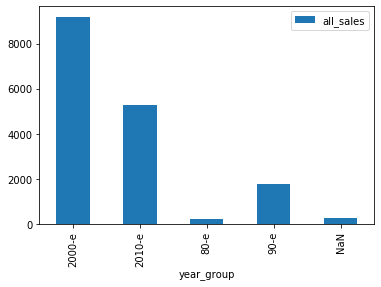

In [22]:
years_ten.plot(kind='bar')


Видно, что наибольшее количество игр было продано в 2000-ых годах, но это может быть связано и с тем, что 2010-ые ограничились пока до 2016 года и вполне могут обогнать 2000-ые.

Теперь посмотрим распредение по платформам

In [23]:
platforms = df.pivot_table(index='platform', values='all_sales', aggfunc='sum')

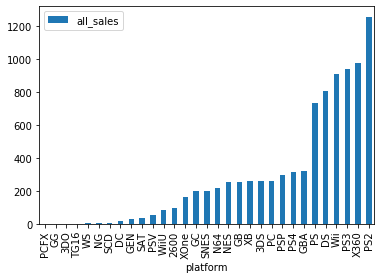

In [24]:
platforms.sort_values(by='all_sales').plot(kind='bar')

На этом графике видно, что наиболее доходные платформы PS2, DS, PS3, Wii, X360, PS

In [25]:
popular_platforms = df.pivot_table(index='platform', values='all_sales', aggfunc='sum').nlargest(5, 'all_sales')

In [26]:
popular_platforms

,all_sales
platform,
PS2,1255.77
X360,971.42
PS3,939.65
Wii,907.51
DS,806.12


Теперь обратимся к каждой и топ-5 платформам по годам

In [27]:
timeseries = df.pivot_table(index='year_of_release', columns='platform', values='all_sales', aggfunc='sum')

In [28]:
timeseries

platform,2600,3DO,3DS,DC,DS,GB,GBA,GC,GEN,GG,...,SAT,SCD,SNES,TG16,WS,Wii,WiiU,X360,XB,XOne
year_of_release,,,,,,,,,,,,,,,,,,,,,
0,10.50,NaN,1.19,NaN,3.34,1.03,4.97,2.20,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,16.33,NaN,10.18,6.17,NaN
1980,11.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981,35.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982,28.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983,5.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984,0.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985,0.45,NaN,NaN,NaN,0.02,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986,0.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987,1.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Самая рання консоль из списка - ps2, вышла в 2000 году, значит отбросим все значения до

In [29]:
for platform in timeseries.columns:
    if platform not in popular_platforms.index:
        timeseries.drop(platform, axis=1, inplace=True)
timeseries = timeseries[timeseries.index >= 2000]        

In [30]:
timeseries

platform,DS,PS2,PS3,Wii,X360
year_of_release,,,,,
2000,NaN,39.17,NaN,NaN,NaN
2001,NaN,166.43,NaN,NaN,NaN
2002,NaN,205.38,NaN,NaN,NaN
2003,NaN,184.31,NaN,NaN,NaN
2004,17.27,211.81,NaN,NaN,NaN
2005,130.14,160.66,NaN,NaN,8.25
2006,119.81,103.42,20.96,137.15,51.62
2007,146.94,75.99,73.19,152.77,95.41
2008,145.31,53.90,118.52,171.32,135.26


Построим график

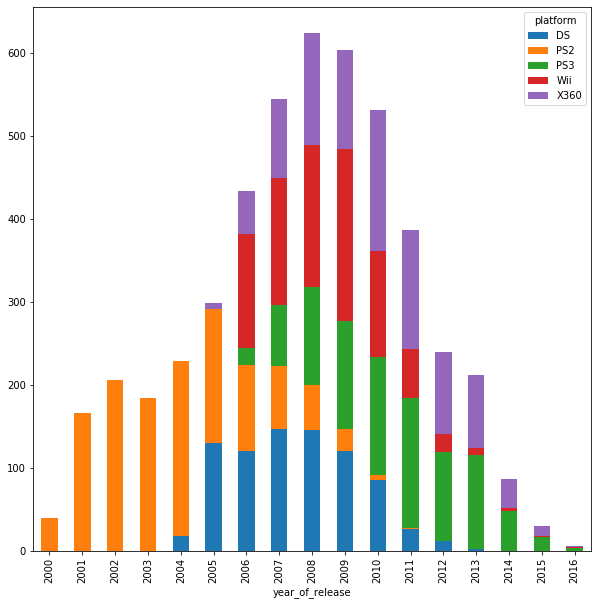

In [31]:
timeseries.plot.bar(stacked=True, figsize=(10,10))

In [32]:
platforms = df['platform'].unique()

In [33]:
platforms

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [34]:
platform_years = df.loc[df['year_of_release'] > 0]

In [35]:
array_of_years = []
for i in platforms:
    maximum = platform_years.loc[platform_years['platform'] == i, 'year_of_release'].max()
    minimum = platform_years.loc[platform_years['platform'] == i, 'year_of_release'].min()
    range_years = (maximum) - (minimum)
    array_of_years.append(range_years)
    

In [36]:
mean_of_array_of_years = sum(array_of_years) / len(array_of_years)

In [37]:
mean_of_array_of_years

7.612903225806452

Глядя на график наиболее популярных платформ за все времена до 2016 года, можно сказать, что примерный срок жизни платформы - 7-9 лет, что на самом деле совпадает с истиной, по крайней мере, которую слышал я - это примерно 8 лет(согласно вычислениям выше - 7.6, что соотвествует моим предположениям, основанным на графике). Кстати, видно, как Sony провалила платформу PS3, сделав ее крайне непригодной для разработки мультиплатформенных игр, зато XBOX360 сильно в этом преуспел, а потому и лидирует по продажам. На самом деле, меня больше всего восхищал всегда успех консолей от Nintendo, и я всегда удивляюсь, как так успешна была Wii, хотя у меня у самого она есть, и насколько я знаю, Switch рискует повторить ее успех.

#### Перейдем к акутальному периоду на 2017 год. 

In [38]:
timeseries_2 = df.pivot_table(index='year_of_release', columns='platform', values='all_sales', aggfunc='sum')

Заранее отбросим все, что было до XBOX360 и PS3 - это слишком древние платформы, ну и цчитывая срок службы платформы в 7-9 лет, обозначим границу в 2010 году.

In [39]:
timeseries_2 = timeseries_2[timeseries_2.index >= 2010] 

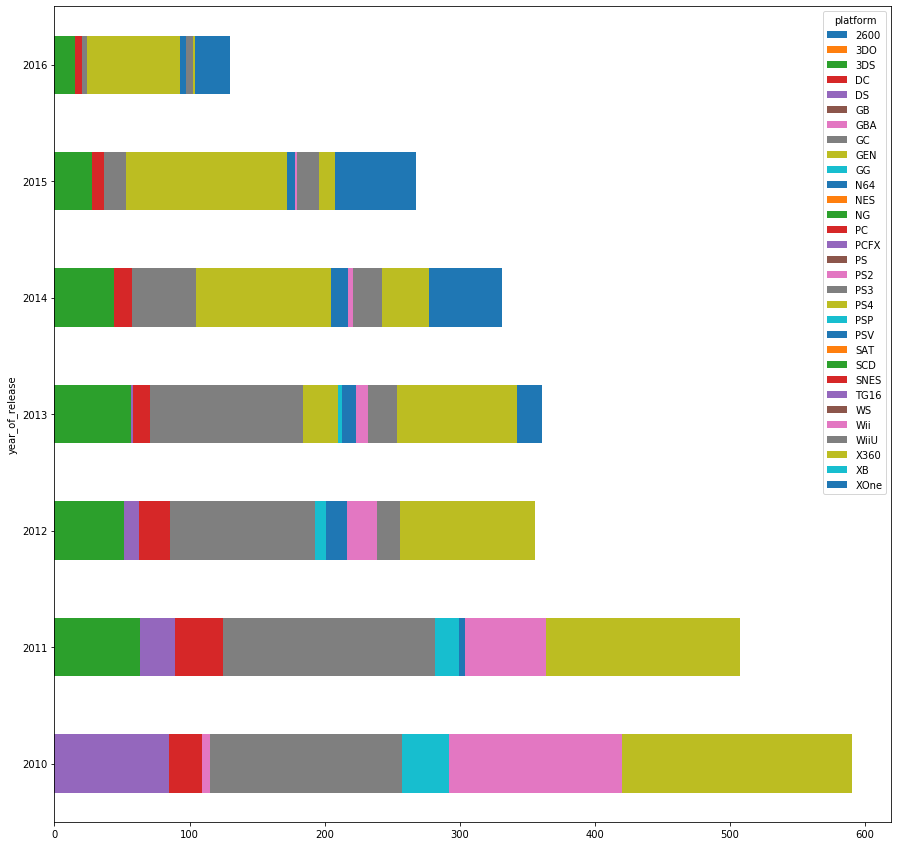

In [40]:
timeseries_2.plot.barh(stacked=True, figsize=(15,15))

Постройм график «ящик с усами» по глобальным продажам игр в разбивке по платформам, но добавим условие: на предыдущем графике видно, что платформа выходит на пик примерно через 3 года после выпуска, вот и обозначим границу на 2014 году, тем более, в том году вышли XBOX one и PS4

(0, 2)

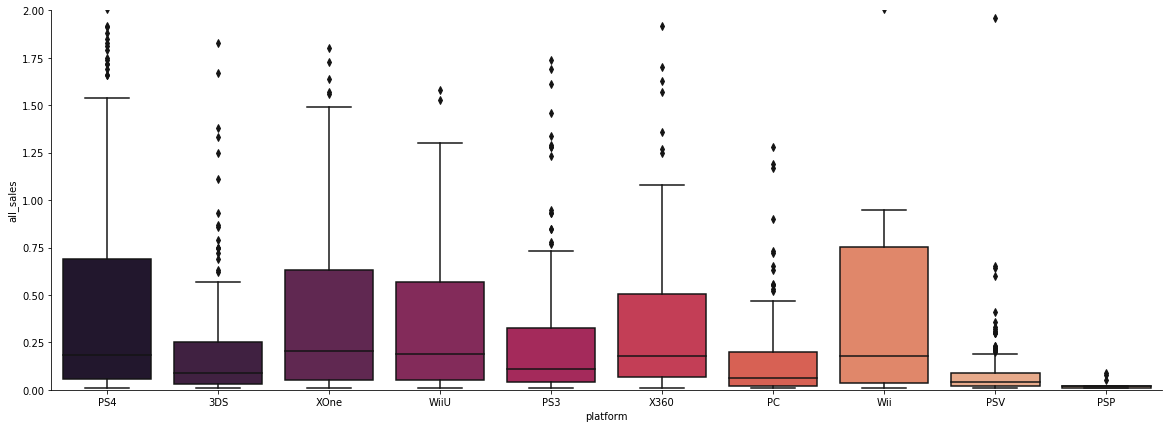

In [41]:
actual_data = df.query('year_of_release >= 2014')
sns.catplot(x="platform", 
            y='all_sales', 
            kind="box", 
            data=actual_data, 
            orient='v', 
            height=6, 
            aspect=2.7, 
            palette='rocket')
plt.ylim(0, 2)

Собственно, выбор не большой, на мой взгляд, лучшим выбором станет PS4, XBOX ONE, ну и PC,  т.к он всегда будет пользоваться относительной популярностью у геймеров, потому что его можно обновлять. Все платформы от Nintendo были популярны, как и X360, но график выше показывает, что к 2016 году они уже почти 'умерли'.

На рынке консолей все примерно так же, как и во всех других отраслях - формально, он не монополизирован, но два, может три, включая Nintendo, игрока полностью владеют рынком игр начиная примерно с 2000 года. За все это время, ни одна компания со стороны со своей платформой не вышла на первые планы. Поэтому, уже давно можно забыть о чем-то экзотическом и просто делать игры на PS, XBOX и PC, при этом учитывая, что рынок PC подвержен пиратству и вообще приносит мало доходов. Да и на последнем графике (ящик с усами) видно, насколько успешны старые консоли на закате своей жизни. 2014 год - год выхода PS4 и XBOX One. А X360 и PS3 все еще в топе продаж, как кстати и почти канувшая в небытие Wii и тем более странный и, на мой взгляд, абсолютно провальный 3DS.

Посмотрим, насколько сильно играет роль отзывов на продажи внутри самой популярной платформы на акутальный период - PS4.

In [42]:
df_PS4 = df.loc[df['platform'] == 'PS4']

In [43]:
df_PS4.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales,year_group
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63,2010-е
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62,2010-е
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58,2010-е
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,NaN,7.98,2010-е
92,Call of Duty: Advanced Warfare,PS4,2014,Shooter,2.81,3.48,0.14,1.23,83.0,5.7,M,7.66,2010-е


Text(0.5, 1.0, 'Расспределение продаж от оценки критиков на PS4')

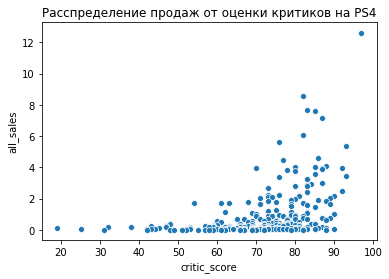

In [44]:
sns.scatterplot(data=df_PS4, x='critic_score', y='all_sales')
plt.title('Расспределение продаж от оценки критиков на PS4')

Text(0.5, 1.0, 'Расспределение продаж от оценки пользователей на PS4')

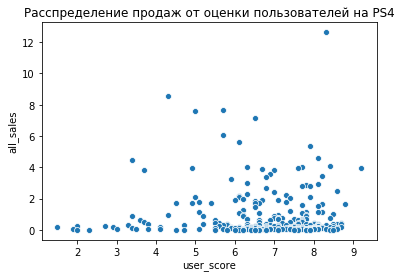

In [45]:
sns.scatterplot(data=df_PS4, x='user_score', y='all_sales')
plt.title('Расспределение продаж от оценки пользователей на PS4')

В целом, видно, что продажи сильно зависят от оценки притиков, в то время как от оценки пользователей уже мало что меняется, есть очень много непредсказуемых показателей, особенно в районе оценки пользователей равной пяти. Предполагаю, что это связано с тем, что пользователи оценивают игру уже после начала продаж, а критики до, формируя предпочтения потенциальных покупателей. "О, боже! 12 из 10" - где-то воскликнул Логвинов, после чего все ринулись брать новую Call of Duty)). Но это на PS4, посмотрим на все платформы.

Text(0.5, 1.0, 'Расспределение продаж от оценки критиков на всех платформах с 2014 года')

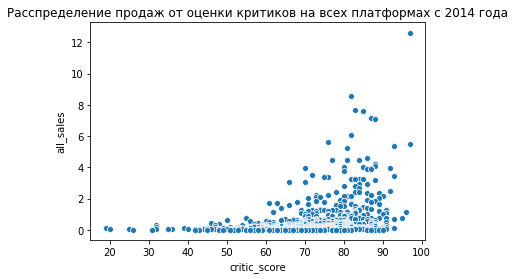

In [46]:
sns.scatterplot(data=actual_data, x='critic_score', y='all_sales')
plt.title('Расспределение продаж от оценки критиков на всех платформах с 2014 года')

Text(0.5, 1.0, 'Расспределение продаж от оценки пользователей на всех платформах с 2014 года')

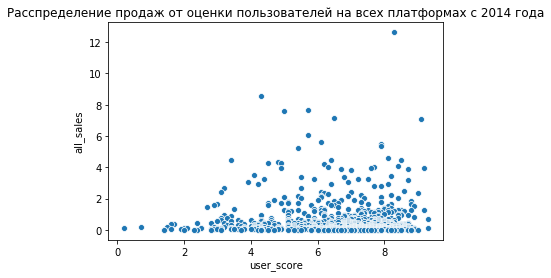

In [47]:
sns.scatterplot(data=actual_data, x='user_score', y='all_sales')
plt.title('Расспределение продаж от оценки пользователей на всех платформах с 2014 года')

In [48]:
actual_data_1 = actual_data[['platform', 'critic_score', 'user_score', 'all_sales']]
actual_data_1.head()

,platform,critic_score,user_score,all_sales
31,PS4,NaN,NaN,14.63
42,PS4,97.0,8.3,12.62
47,3DS,NaN,NaN,11.68
77,PS4,82.0,4.3,8.58
87,PS4,NaN,NaN,7.98


In [49]:
actual_data_1.corr()

,critic_score,user_score,all_sales
critic_score,1.000000,0.50446,0.328105
user_score,0.504460,1.00000,-0.013070
all_sales,0.328105,-0.01307,1.000000


Картина повторяется, с ориентировкой на выгоду лучше обращаться к оценкам критиков, кажется, они оказывают более сильное влияние на потребителя, чем смешные обзоры в Steam, это же показывает и уровень положительной корреляции в 0.328, хоть он и небольшой

Посмотрим на общее распределение игр по жанрам.

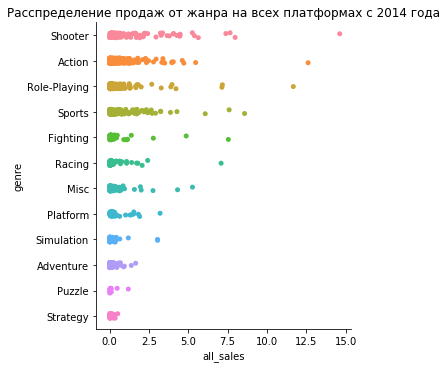

In [50]:
sns.catplot(data=actual_data, y='genre', x='all_sales')
plt.title('Расспределение продаж от жанра на всех платформах с 2014 года')
plt.show()

К сожалению, совсем не могу понять, почему появляется вторая часть графика, ума не приложу, честно. Но что касается вывода, то он очевиден - выбираем Шутер, Экшен, РПГ или Спортивную и срываем куш, а чтобы совсем взорвать мохг потребителем, делаем спортивную рпг в жанре экшен с активной шутерной частью, все деньги мира нам обеспечены.

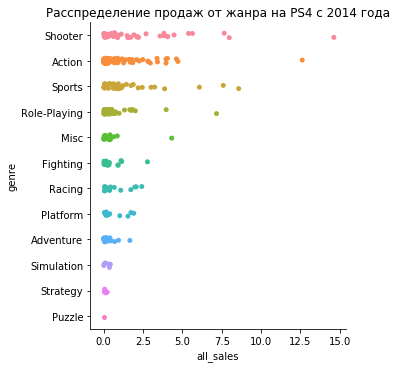

In [51]:
sns.catplot(data=df_PS4, y='genre', x='all_sales')
plt.title('Расспределение продаж от жанра на PS4 с 2014 года')
plt.show()

Но если обратиться к консольныму экспериенсу, то я бы советовал, как и этот график, РПГ обходить стороной - это не сильная сторона консолей ввиду управления геймпадом.

# Этап 4.

### Составим портрет пользователя в каждом из регионов.

In [52]:
actual_data['rating'].unique()

array([nan, 'M', 'E', 'T', 'E10+'], dtype=object)

Специально для следующих вычислений заменю Nan в рейтинге на No_rating

In [53]:
actual_data['rating'] = actual_data['rating'].fillna('no_rating')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [54]:
actual_data['rating'].unique()

array(['no_rating', 'M', 'E', 'T', 'E10+'], dtype=object)

In [55]:
regions_list = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']
criterions = ['platform', 'genre', 'rating']

Общая сумма продаж = 284.06000000000006



,platform,na_sales,ratio
3,PS4,98.61,34.714497
9,XOne,81.27,28.610153
8,X360,28.30,9.962684
0,3DS,22.64,7.970147
2,PS3,22.05,7.762445



-------------------------------

Общая сумма продаж = 270.67999999999995



,platform,eu_sales,ratio
3,PS4,130.04,48.041968
9,XOne,46.25,17.086597
2,PS3,25.54,9.435496
1,PC,17.97,6.638836
0,3DS,16.12,5.955372



-------------------------------

Общая сумма продаж = 93.09



,platform,jp_sales,ratio
0,3DS,44.24,47.523902
3,PS4,15.02,16.134923
5,PSV,14.54,15.619293
2,PS3,11.22,12.052852
7,WiiU,7.31,7.852616



-------------------------------

Общая сумма продаж = 81.62



,platform,other_sales,ratio
3,PS4,44.48,54.496447
9,XOne,12.52,15.339378
2,PS3,9.37,11.480029
8,X360,4.35,5.329576
0,3DS,3.68,4.508699



-------------------------------

Общая сумма продаж = 284.06000000000006



,genre,na_sales,ratio
8,Shooter,79.02,27.818067
0,Action,72.53,25.533338
10,Sports,46.13,16.239527
7,Role-Playing,33.47,11.782722
3,Misc,15.05,5.298176



-------------------------------

Общая сумма продаж = 270.67999999999995



,genre,eu_sales,ratio
0,Action,74.68,27.589774
8,Shooter,65.52,24.205704
10,Sports,45.73,16.894488
7,Role-Playing,28.17,10.407123
6,Racing,14.13,5.220186



-------------------------------

Общая сумма продаж = 93.09



,genre,jp_sales,ratio
7,Role-Playing,31.16,33.472983
0,Action,29.58,31.775701
2,Fighting,6.37,6.842840
3,Misc,5.61,6.026426
8,Shooter,4.87,5.231496



-------------------------------

Общая сумма продаж = 81.62



,genre,other_sales,ratio
0,Action,22.57,27.652536
8,Shooter,21.53,26.378339
10,Sports,14.36,17.593727
7,Role-Playing,8.64,10.585641
3,Misc,4.03,4.937515



-------------------------------

Общая сумма продаж = 284.06000000000006



,rating,na_sales,ratio
2,M,96.42,33.943533
4,no_rating,64.72,22.783919
0,E,50.74,17.862423
3,T,38.95,13.711892
1,E10+,33.23,11.698233



-------------------------------

Общая сумма продаж = 270.67999999999995



,rating,eu_sales,ratio
2,M,93.44,34.520467
4,no_rating,58.95,21.778484
0,E,58.06,21.449682
3,T,34.07,12.586818
1,E10+,26.16,9.664549



-------------------------------

Общая сумма продаж = 93.09



,rating,jp_sales,ratio
4,no_rating,56.90,61.123644
3,T,14.78,15.877108
0,E,8.94,9.603609
2,M,8.01,8.604576
1,E10+,4.46,4.791062



-------------------------------

Общая сумма продаж = 81.62



,rating,other_sales,ratio
2,M,28.67,35.126195
4,no_rating,18.40,22.543494
0,E,15.39,18.855673
3,T,11.33,13.881402
1,E10+,7.83,9.593237



-------------------------------



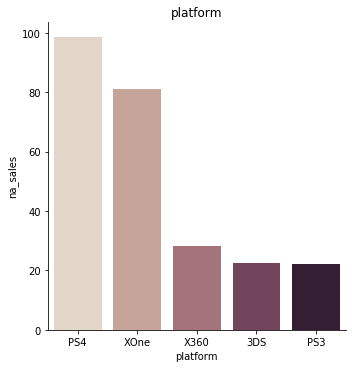

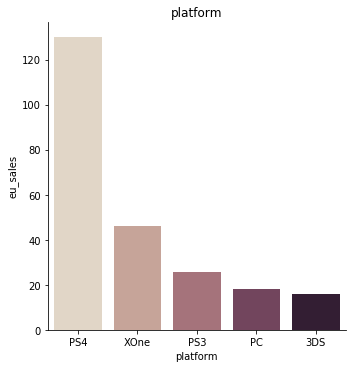

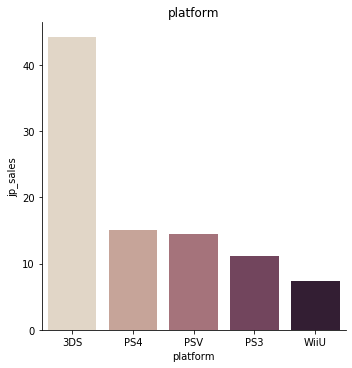

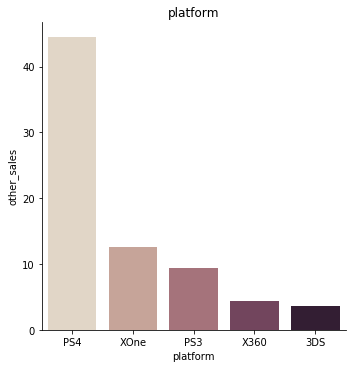

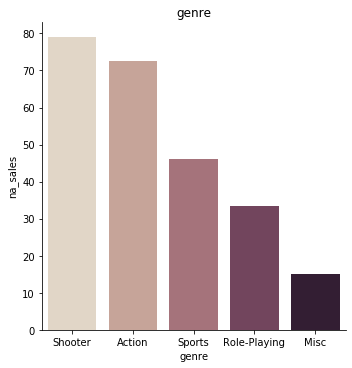

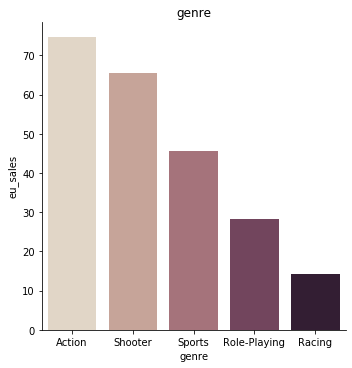

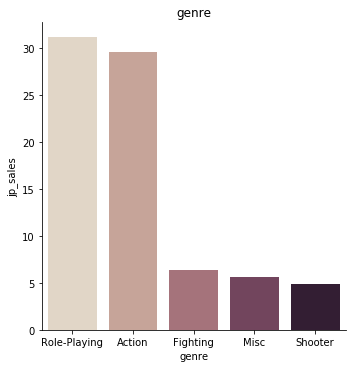

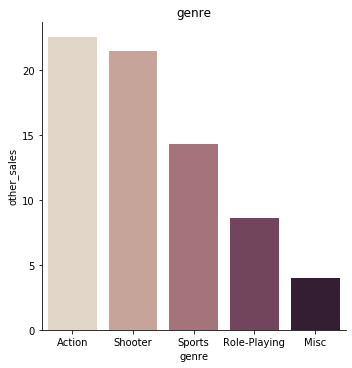

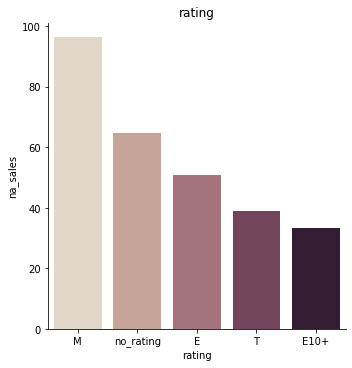

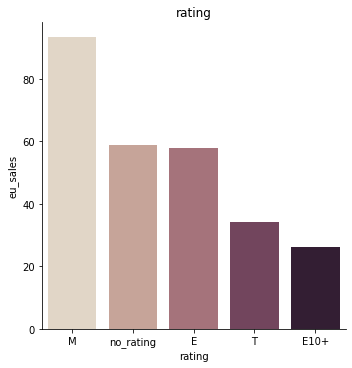

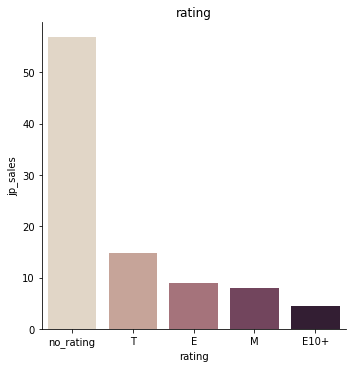

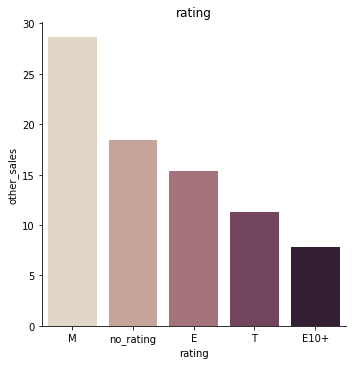

In [56]:
x = 0
for j in criterions:
    for i in regions_list:
        pivot_1 = actual_data.pivot_table(index=j, values=i, aggfunc='sum').reset_index().nlargest(5, i)
        print('Общая сумма продаж =', actual_data[i].sum())
        print()
        pivot_1['ratio'] = (pivot_1[i] / actual_data[i].sum()) * 100
        display(pivot_1)
        print()
        sns.catplot(x=j, y=i, kind='bar', palette="ch:.25", data=pivot_1)
        plt.show
        plt.title(criterions[x])
        print('-------------------------------')
        print()
    x+=1   

Looking at these summary tables, you can once again make sure that the PS4 is the best platform for releasing games, except, of course, Japan, but they are generally strange and love their canonical platforms from Nintendo, but all presented in the top have long been outdated, so the universal choice, in my opinion, any user around the world will be PS4, well, or XBOX one, except Japan, again. It's amazing to see that PC gaming is used mostly in Europe. In North America, consoles are preferred.
Now, as for genres by region-North America is a fan of shooters, action games, sports games and RPGs; Europe-from the same; expect a lot of RPG fans in Japan, I'm sure their favorite type is jRPG, and also fighting games, it is noteworthy that most of the original fighting games were invented in Japan. In the rest of the world, the preferences are the same as in Europe and North America.
About ratings: the picture is the same all over the world-M and E ratings dominate, which corresponds to 17+ and 0+, which is not surprising, because the most popular genres are shooters and sports games. But in Japan, everything is again not like everyone else - the most popular rating is T(13+), but the genre there is the most popular RPG, logically, they are not so bloody.

# Этап 5.

### Проверим гипотезы.

Сравним платфомы XBOX One и PC

Формируем гипотезы таким образом, чтобы нулевая гипотеза описывала простое равенство двух событий, альтернативную гипотезу строим от противного к нулевой. Использовать будем ttest_ind, параметр equal_var выставим False, хотя отдаленно выборки должны быть похожими, ввиду того, что XBOX и PC имеют почти, одинаковую базу игр, по крайней мере то, что касается крупных проектов, но на ПК больше инди-игр и прочего.

In [57]:
actual_data_2 = df.loc[df['year_of_release'] > 2014]

Проверим дисперсии выборок, чтобы объяснить выбор параметра equal_var.

In [58]:
print(actual_data_2.query('platform == "XOne"')['user_score'].dropna().var())
print(actual_data_2.query('platform == "PC"')['user_score'].dropna().var())

2.125792011019284
3.110950946643718


H0  — средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

H1  — средние пользовательские рейтинги платформ Xbox One и PC различаются.

In [59]:
xone = actual_data_2.query('platform == "XOne"')['user_score'].dropna()
pc = actual_data_2.query('platform == "PC"')['user_score'].dropna()

alpha = .05

results = st.ttest_ind(
    xone, 
    pc,
    equal_var = False)

print(results)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Ttest_indResult(statistic=1.0515500933673056, pvalue=0.2946308864003345)
p-значение: 0.2946308864003345
Не получилось отвергнуть нулевую гипотезу


Нулевая гипотеза подтвердилась, что свидельствует о том, что у PC и XBOX игры, в целом, одинаковые, что не может сильно влиять на разные оценки, дальше уже дело в оптимизации.

H0  — средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») одинаковые.

H1 — средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные.

In [60]:
print(actual_data_2.query('genre == "Action"')['user_score'].dropna().var())
print(actual_data_2.query('genre == "Sports"')['user_score'].dropna().var())

1.81305591537133
3.8724676302318572


In [61]:
action = actual_data_2.query('genre == "Action"')['user_score'].dropna()
sports = actual_data_2.query('genre == "Sports"')['user_score'].dropna()

alpha = .05

results = st.ttest_ind(
    action, 
    sports, 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 5.97163549920592e-10
Отвергаем нулевую гипотезу


Получается, что нулевую гипотезу мы отвергаем и средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные.

# Step 6. General output.

So, what is the result of all this work done? After analyzing the information, I came to the conclusion that, in order to achieve maximum profit from the game, you need to take into account several factors.
- first, and most importantly, we need to focus on the new generation of consoles: PS4 and XBOX One, they are the most popular, set trends in genres, in particular, the most popular genres around the world - shooters and action, which are well adapted to consoles, but with RPGs, which are also popular, especially in Japan, a little more difficult, they do not go well with the existing controls on consoles, and therefore, I would suggest that this would not be the best choice.
- you need to look at the potential market, if the trends around the world are about the same, then Japan is quite unique, and portable consoles from Nintendo are very popular there, and also in genres the preferences there are slightly different from the rest of the world.
- it is necessary to focus on the ratings of critics, they form the ideas of a potential buyer and push them to make a purchase, which can not be said about the ratings of ordinary users.
- the best rating of the game will be the limit of 17+, for some games in the Sport genre-13+, this, as I have already mentioned above, is due to preferences in genres, action and shooter without cruelty - a bad project, most likely).